# Scan rig crosstalk analysis

Background fluorescence in the 700 nm channel has been highlighted as a problem - particularly in scan rig 3, but also in the other two scan rigs. Narrowing the 700 channel emission filter will affect the % crosstalk performance. How much?

First perform setup, including setting relative paths of spectra files. 

In [26]:
import os
import numpy as np
import matplotlib.pyplot as plt

from dye import Dye
from laser import Laser
from filterCube import FilterCube
from camera import Camera
from objective import Objective
import utils
from crosstalk_analysis import signalFromDyeXInChannelY
from crosstalk_analysis import displayCrosstalkPlot

dyesPath = 'Dye spectra/'
filtersPath = 'Filter spectra/'
opticsPath =  'Optics spectra/'
cameraPath = 'Camera spectra/'

__Sources for dye data:__

Atto general properties: https://www.atto-tec.com/fileadmin/user_upload/Katalog_Flyer_Support/Dye_Properties_01.pdf

Atto spectra: https://www.atto-tec.com/attotecshop/product_info.php?language=en&info=p117_ATTO-700.html

Alexa 405 absorption coefficient: http://www.atdbio.com/content/34/Alexa-dyes

Alexa 405 QY: http://confocal-microscopy-list.588098.n2.nabble.com/alexa-405-QY-td6913848.html

Alexa 405 spectra: https://www.chroma.com/spectra-viewer?fluorochromes=10533


__Sources for filter spectra:__

Semrock filters: http://www.laser2000.co.uk

Chroma 700 dichroics: emailed from Chroma


__Sources for camera spectra:__

Andor Zyla 5.5: https://searchlight.semrock.com/


__Sources for optics (objective) spectra:__

UPLANSAPO20x: https://www.olympus-lifescience.com/en/objectives/uplsapo/#!cms[tab]=%2Fobjectives%2Fuplsapo%2F20x, data extracted from curve using WebPlotDigitiser: http://arohatgi.info/WebPlotDigitizer/app/


Next, define (manually and in a boilerplate-y manner) the components of the system we are investigating. 

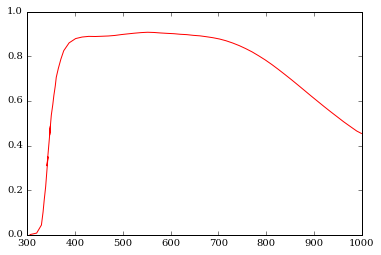

In [27]:
dye405 = Dye(name = 'Alexa405', epsilon = 35000, qy = 0.54, 
             absSpectrum = os.path.join(dyesPath, 'Alexa405abs.txt'), 
             emSpectrum = os.path.join(dyesPath, 'Alexa405em.txt'))
          
dye532 = Dye(name = 'Atto532', epsilon = 115000, qy = 0.9, 
             absSpectrum = os.path.join(dyesPath, 'ATTO532_PBS.abs.txt'), 
             emSpectrum = os.path.join(dyesPath, 'ATTO532_PBS.ems.txt'))

dye594 = Dye(name = 'Atto594', epsilon = 120000, qy = 0.85, 
             absSpectrum = os.path.join(dyesPath, 'ATTO594_PBS.abs.txt'), 
             emSpectrum = os.path.join(dyesPath, 'ATTO594_PBS.ems.txt'))

dye633 = Dye(name = "Atto655", epsilon = 125000, qy = 0.3, 
          absSpectrum = os.path.join(dyesPath, 'ATTO655_PBS.abs.txt'), 
          emSpectrum = os.path.join(dyesPath, 'ATTO655_PBS.ems.txt') )        

dye700 = Dye(name = "Atto700", epsilon = 120000, qy = 0.25, 
          absSpectrum = os.path.join(dyesPath, 'ATTO700_PBS.abs.txt'), 
          emSpectrum = os.path.join(dyesPath, 'ATTO700_PBS.ems.txt') )         
          
l405 = Laser(channel = 'L405Nm', centreWavelengthNm = 405, fwhmNm = 0.01, 
             laserOutputPowerMw = 3)
             
l532 = Laser(channel = 'L532Nm', centreWavelengthNm = 532, fwhmNm = 0.01, 
             laserOutputPowerMw = 18)
             
l594 = Laser(channel = 'L594Nm', centreWavelengthNm = 594, fwhmNm = 0.01, 
             laserOutputPowerMw = 25)             
          
l633 = Laser(channel = 'L633Nm', centreWavelengthNm = 640, fwhmNm = 0.01, 
             laserOutputPowerMw = 30)
          
l700 = Laser(channel = 'L700Nm', centreWavelengthNm = 701, fwhmNm = 0.01, 
             laserOutputPowerMw = 30)
             
fc405 = FilterCube(channel = 'L405Nm', 
                   excitationFilter = ( 'FF01-390_40', os.path.join(filtersPath, 'FF01-390_40_Spectrum.txt') ), 
                   dichroicFilter = ( 'Di02-R405', os.path.join(filtersPath, 'Di02-R405_Spectrum.txt') ), 
                   emissionFilter = ( 'FF01-452_45', os.path.join(filtersPath, 'FF01-452_45_Spectrum.txt') ) )
                   
fc532 = FilterCube(channel = 'L532Nm', 
                   excitationFilter = ( 'FF01-532_3', os.path.join(filtersPath, 'FF01-532_3_spectrum.txt') ), 
                   dichroicFilter = ( 'Di02-R532', os.path.join(filtersPath, 'Di02-R532_Spectrum.txt') ), 
                   emissionFilter = ( 'FF01-562_40', os.path.join(filtersPath, 'FF01-562_40_spectrum.txt') ) )
                   
fc594 = FilterCube(channel = 'L594Nm', 
                   excitationFilter = ( 'FF01-591_6', os.path.join(filtersPath, 'FF01-591_6_Spectrum.txt') ), 
                   dichroicFilter = ( 'Di02-R594', os.path.join(filtersPath, 'Di02-R594_Spectrum.txt') ), 
                   emissionFilter = ( 'FF01-647_57', os.path.join(filtersPath, 'FF01-647_57_Spectrum.txt') ) )
             
fc633 = FilterCube(channel = 'L633Nm', 
                   excitationFilter = ( 'FF01-640_14', os.path.join(filtersPath, 'FF01-640_14_spectrum.txt') ), 
                   dichroicFilter = ( 'Di02-R635', os.path.join(filtersPath, 'Di02-R635_Spectrum.txt') ), 
                   emissionFilter = ( 'FF01-679_41', os.path.join(filtersPath, 'FF01-679_41_Spectrum.txt') ) )
                   
fc700old = FilterCube(channel = 'L700Nm', 
                   excitationFilter = ( 'FF01-692_40', os.path.join(filtersPath, 'FF01-692_40_Spectrum.txt') ), 
                   dichroicFilter = ( '725dcxxr', os.path.join(filtersPath, 'Chroma 725dcxxr.txt') ), 
                   emissionFilter = ( 'FF01-795_150', os.path.join(filtersPath, 'FF01-795_150_Spectrum.txt') ) )
                   
fc700new = FilterCube(channel = 'L700Nm', 
                   excitationFilter = ( 'FF01-692_40', os.path.join(filtersPath, 'FF01-692_40_Spectrum.txt') ), 
                   dichroicFilter = ( '725lpxr', os.path.join(filtersPath, 'Chroma 725lpxr.txt') ), 
                   emissionFilter = ( 'FF01-747_33', os.path.join(filtersPath, 'FF01-747_33_Spectrum.txt') ) )
                   
                   
camera = Camera(name = 'Andor Zyla 5.5', 
                qeCurve = os.path.join(cameraPath, 'Camera sCMOS (Andor- Zyla 5.5).txt'))

objective = Objective(name = 'Olympus UPLANSAPO20x 0.75NA', 
                      transmissionCurve = os.path.join(opticsPath, 'Olympus UPLANSAPO20x.txt'))



Perfom a direct comparison of the crosstalk from 633 dye into the old and new 700 nm detection channels. 

In [28]:
d, ch, sig = signalFromDyeXInChannelY(l700, fc700old, dye700, objective, camera)
d, ch, ct = signalFromDyeXInChannelY(l700, fc700old, dye633, objective, camera)

print('Crosstalk from 633 in old 700 channel as a % of signal:')
ct_old = 100*ct/sig
print(ct_old)

d, ch, sig = signalFromDyeXInChannelY(l700, fc700new, dye700, objective, camera)
d, ch, ct = signalFromDyeXInChannelY(l700, fc700new, dye633, objective, camera)

print('Crosstalk from 633 in new 700 channel as a % of signal:')
ct_new = 100*ct/sig
print(ct_new)


Crosstalk from 633 in old 700 channel as a % of signal:
1.82506941578
Crosstalk from 633 in new 700 channel as a % of signal:
2.01371409331


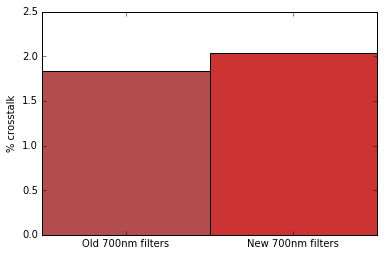

In [5]:
% matplotlib inline
plt.bar([1, 2], [ct_old, ct_new], width=[1, 1], tick_label=['Old 700nm filters', 'New 700nm filters'], 
        align='center', color=[(0.7 ,0.3, 0.3), (0.8, 0.2, 0.2)])
plt.ylabel('% crosstalk')

C:\Users\d.kelly\Documents\DyeAnalysis\crosstalk_analysis.py:96: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(crosstalkMatrix), cmap = 'Reds', interpolation='none')


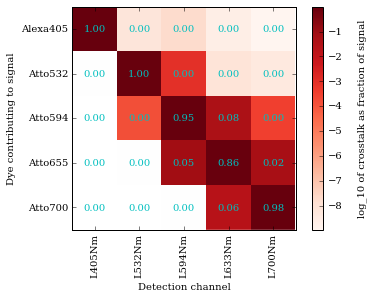

array([[  9.99999970e-01,   6.99098637e-09,   1.97068485e-08,
          2.63177022e-09,   1.12792886e-09],
       [  0.00000000e+00,   9.98966847e-01,   1.03313858e-03,
          9.12676634e-09,   5.02826886e-09],
       [  0.00000000e+00,   1.32754106e-04,   9.54331344e-01,
          4.51905361e-02,   3.45366027e-04],
       [  0.00000000e+00,   0.00000000e+00,   7.99107899e-02,
          8.62085629e-01,   5.80035810e-02],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.97396410e-02,   9.80260359e-01]])

In [29]:
displayCrosstalkPlot([l405, l532, l594, l633, l700], 
                     [fc405, fc532, fc594, fc633, fc700new], 
                     [dye405, dye532, dye594, dye633, dye700], 
                     objective, camera)